# Laplace-Lagrange Secular Theory

This notebook illustrates `celmech`'s `LaplaceLagrangeSystem` class, which provides the Laplace-Lagrange solution for the secular dynamics of a planetary system. A `LaplaceLagrangeSystem` system can be initialized directly from a `rebound` simulation using the `from_Simulation` class method or from a `Poincare` object using the `from_Poincare` class method.

The Laplace-Lagrange theory formulates the equations of motion governing a planetary system's eccentricities and inclinations as de-coupled linear differential equations. 

In terms of the complex canonical variables
$$
\begin{eqnarray}
x_i &= \sqrt{\Lambda_i(1-\sqrt{1-e_i^2})}\exp[\mathrm{i}\varpi_i]\\
y_i &= \sqrt{2\Lambda\sqrt{1-e_i^2}}\sin(I_i/2)\exp[\mathrm{i}\Omega_i]~,
\end{eqnarray}
$$
 where $\Lambda = m_i\sqrt{GM_ia_i}$, the Laplace-Largange equations of motion may be written as 
$$
\begin{align}
\frac{d}{dt}
\begin{pmatrix}
 x_1\\
 x_2\\
 \vdots\\
 x_N
 \end{pmatrix}
  &= -\sqrt{-1}\pmb{S}_e \cdot \begin{pmatrix}
 x_1\\
 x_2\\
 \vdots\\
 x_N
 \end{pmatrix} 
 \\ %%%%%%%% y eqn %%%%%%%%%%%%%%%
 \frac{d}{dt}
\begin{pmatrix}
 y_1\\
 y_2\\
 \vdots\\
 y_N
 \end{pmatrix}
  &= -\sqrt{-1}\pmb{S}_I \cdot \begin{pmatrix}
 y_1\\
 y_2\\
 \vdots\\
 y_N
 \end{pmatrix}
 \end{align}
$$
which are derived from the Hamiltonian
$$
H = \pmb{x}^{T} \cdot\pmb{S}_e\cdot\bar{\pmb{x}} +\pmb{y}^{T} \cdot\pmb{S}_I\cdot\bar{\pmb{y}}
$$
where overbars denote complex conjugates.
The `LaplaceLagrangeSystem` stores both symbolic and numerical expressions for the matrices $\pmb{S}_e$ and $\pmb{S}_I$ as object attributes `eccentricity_matrix` and `inclination_matrix` and attributes `Neccentricity_matrix` and `Ninclination_matrix`, respectively. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from celmech.nbody_simulation_utilities import set_time_step,align_simulation
from celmech.nbody_simulation_utilities import get_simarchive_integration_results
import rebound as rb
from os.path import isfile
from sympy import init_printing
init_printing()

In [2]:
from celmech.secular import LaplaceLagrangeSystem

### Set up `rebound` simulation

In [3]:
try:
    sa = rb.Simulationarchive('sa_laplace_lagrange.bin')
except RuntimeError:
    np.random.seed(1)
    sim = rb.Simulation()
    sim.add(m=1)
    m = 5e-5
    sigma_e = 0.02
    sigma_inc = sigma_e / 2
    for a in np.linspace(1,8,4):
        sim.add(
            m=m / np.sqrt(a),
            a=a,
            e=np.random.rayleigh(sigma_e),
            inc=np.random.rayleigh(sigma_inc),
            pomega = "uniform",
            Omega = "uniform",
            l="uniform"
        )
    sim.integrator = 'whfast'
    set_time_step(sim,1/40)
    sim.ri_whfast.safe_mode = 0
    sim.move_to_com()
    align_simulation(sim)
    
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)
    eigvals = lsys.eccentricity_eigenvalues()
    Tsec = np.max(np.abs(2 * np.pi / eigvals))
    sim.save_to_file('sa_laplace_lagrange.bin',interval=Tsec/2048,delete_file=True)
    sim.integrate(0.5*Tsec)
    sa = rb.Simulationarchive('sa_laplace_lagrange.bin')

### Set up Laplace-Lagrange secular system corresponding to the `rebound` simulation

In [4]:
nb_results = get_simarchive_integration_results(sa)
sim = sa[0]
lsys = LaplaceLagrangeSystem.from_Simulation(sim)
sec_soln = lsys.secular_solution(nb_results['time'])

/fs/lustre/cita/hadden/miniconda3/envs/celmech/lib/python3.11/site-packages/rebound/simulationarchive.py:144: RuntimeWarning: The simulation might not be synchronized. You can manually synchronize it by calling sim.integrator_synchronize().
  warnings.warn("The simulation might not be synchronized. You can manually synchronize it by calling sim.integrator_synchronize().", RuntimeWarning)


In [5]:
lsys.eccentricity_matrix

⎡                                                        2            2                                                         2            
⎢  2⋅C_{(0,0,0,0,0,0)}_{1,2})__{(0,0,1,0),(0,0)}(\alpha⋅G ⋅M₂⋅m₁⋅m₂⋅μ₂    2⋅C_{(0,0,0,0,0,0)}_{1,3})__{(0,0,1,0),(0,0)}(\alpha⋅G ⋅M₃⋅m₁⋅m₃⋅μ₃
⎢- ──────────────────────────────────────────────────────────────────── - ───────────────────────────────────────────────────────────────────
⎢                                      2                                                                      2                              
⎢                                 Λ₁⋅Λ₂                                                                  Λ₁⋅Λ₃                               
⎢                                                                                                                                            
⎢                                                                                                                             2            2 
⎢     

## Compare $N$-body solution to the Laplac-Lagrange secular solution

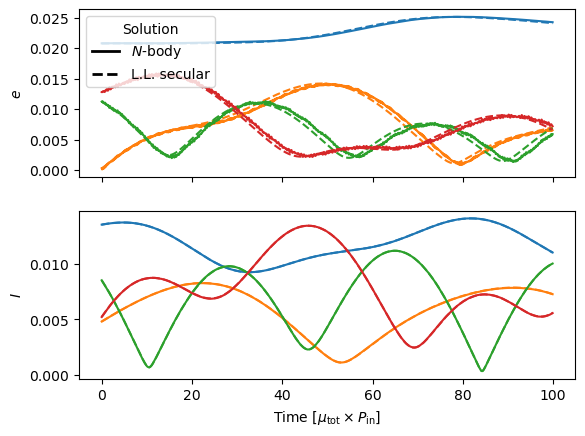

In [6]:
fig,ax = plt.subplots(2,1,sharex=True)
Time = nb_results['time'] / sim.particles[1].P * np.sum([p.m for p in sim.particles[1:]])
for i in range(lsys.N-1):
    l,=ax[0].plot(Time ,nb_results['e'][i])
    ax[0].plot(Time,sec_soln['e'][i],color=l.get_color(),ls='--')
    l,=ax[1].plot(Time,nb_results['inc'][i])
    ax[1].plot(Time,sec_soln['inc'][i],ls='--',color=l.get_color())   
ax[1].set_xlabel(r'Time [$\mu_\mathrm{tot} \times P_\mathrm{in} $]')
ax[0].set_ylabel('$e$')
ax[1].set_ylabel('$I$')
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='k',lw=2, ls='-'),
                Line2D([0], [0], color='k',lw=2, ls='--')]
ax[0].legend(custom_lines, [r'$N$-body',"L.L. secular"],loc='upper left',title='Solution')

### Secular modes

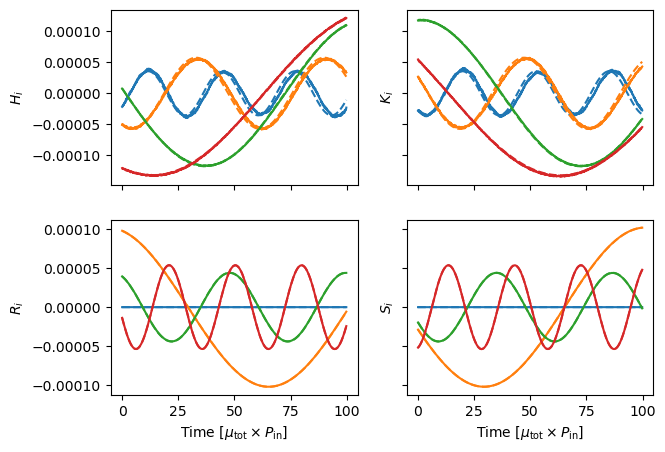

In [7]:
T,D = lsys.diagonalize_eccentricity()
nb_results['Lambda'] = np.array([p.m * np.sqrt(lsys.G * p.M) for p in lsys.particles[1:]]).reshape(-1,1) * np.sqrt(nb_results['a'])
nb_results['Gamma'] = nb_results['Lambda'] * (1 - np.sqrt(1 - nb_results['e']**2))
nb_results['eta'] = np.sqrt(2 * nb_results['Gamma'])  * np.sin(-1 * nb_results['pomega'])
nb_results['kappa'] = np.sqrt(2 * nb_results['Gamma'])  * np.cos(-1 * nb_results['pomega'])
nb_results['H'] = T.T @ nb_results['eta']
nb_results['K'] = T.T @ nb_results['kappa']
nb_results['Q'] = (nb_results['Lambda'] - nb_results['Gamma']) * (1 - np.cos(nb_results['inc']))

nb_results['sigma'] = np.sqrt(2 * nb_results['Q']) * np.cos(-1 * nb_results['Omega'])
nb_results['rho'] = np.sqrt(2 * nb_results['Q']) * np.sin(-1 * nb_results['Omega'])

U,D = lsys.diagonalize_inclination()
nb_results['R'] = U.T @ nb_results['rho']
nb_results['S'] = U.T @ nb_results['sigma']


fig,ax = plt.subplots(2,2,sharex=True,sharey='row',figsize=(7,5))
for l,pair in enumerate([('H','K'),('R','S')]):
    for m,var in enumerate(pair):
        for i in range(lsys.N-1):
            line, = ax[l,m].plot(Time,nb_results[var][i],ls='-')
            ax[l,m].plot(Time,sec_soln[var][i],ls='--',color=line.get_color())
        ax[l,m].set_ylabel(r'${}_i$'.format(var));    
ax[1,0].set_xlabel(r'Time [$\mu_\mathrm{tot} \times P_\mathrm{in} $]');
ax[1,1].set_xlabel(r'Time [$\mu_\mathrm{tot} \times P_\mathrm{in} $]');

# Applying correction to Laplace-Lagrange theory from first-order MMRs
The secular dynamics of a planetary systems can be significantly altered if any pairs of planets are close to a $k$:$k-1$ first-order mean motion resonance. The secular terms in the equations arising from the influence of a first-order MMR are second order in the planet-star mass ratios (${\cal O}(\mu^2)$), but can be comparable to or larger than the ${\cal O}(\mu)$ terms due to the presence of a small resonant denominator. In particular, the dominant secular contribution of a first-order resonance is $ \propto \frac{k^2 \mu^2 n'}{kn' - (k-1)n}$, which can be significant close to resonance. The `LaplaceLagrangeSystem` class provides the `add_first_order_resonance_term` and `add_first_order_resonance_terms` mehtods to include corrections to the secular equations of motion arising from a first-order MMR. The example below demonstrates how these methods are used and compares the accuracy of the `LaplaceLagrangeSystem` to $N$-body with and without this correction.

In [8]:
def get_sim(pratio):
    sim = rb.Simulation()
    sim.add(m=1)
    sim.add(m = 3e-5, P = 1 ,e = 0.01, inc = 0.01, pomega = 0)
    sim.add(m = 3e-5, P = pratio ,e = 0.01, pomega = np.pi/2)
    sim.integrator = 'whfast'
    sim.ri_whfast.safe_mode = 0 
    set_time_step(sim,1/27.)    
    sim.move_to_com()
    align_simulation(sim)
    return sim



### Set resonance

In [9]:
kres = 3

### Set up simulation near resonance
 Set $P_2 = \frac{k_\mathrm{res}}{k_\mathrm{res}-1}P_1(1+\Delta_0)$

In [10]:
Delta0 = 0.02
sim = get_sim(kres * (1 + 0.02) / (kres - 1))
llsys = LaplaceLagrangeSystem.from_Simulation(sim)
Tmax = 4 * np.max( 2 * np.pi / np.abs(llsys.eccentricity_eigenvalues()) ) 

### $\pmb{S}_e$ Matrix without resonance correction

In [11]:
llsys.eccentricity_matrix

⎡                                                       2            2                                                         2            2
⎢-2⋅C_{(0,0,0,0,0,0)}_{1,2})__{(0,0,1,0),(0,0)}(\alpha⋅G ⋅M₂⋅m₁⋅m₂⋅μ₂    -C_{(0,0,1,-1,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G ⋅M₂⋅m₁⋅m₂⋅μ₂ 
⎢──────────────────────────────────────────────────────────────────────  ────────────────────────────────────────────────────────────────────
⎢                                     2                                                                 ____   5/2                           
⎢                                Λ₁⋅Λ₂                                                                ╲╱ Λ₁ ⋅Λ₂                              
⎢                                                                                                                                            
⎢                                                      2            2                                                           2            
⎢-C_{(

In [12]:
llsys.Neccentricity_matrix

array([[-0.00029745,  0.00023804],
       [ 0.00023804, -0.00025814]])

### $\pmb{S}_e$ Matrix with resonance correction

In [13]:
from sympy import S
from celmech.disturbing_function import get_df_coefficient_symbol

In [14]:
llsys.add_first_order_resonance_term(1,2,kres)
# Using substitution {Cin:S('C1'),Cout:S('C2')} to make result more legible
Cin = get_df_coefficient_symbol(kres,1-kres,-1,0,0,0,0,0,0,0,0,0,1,2)
Cout = get_df_coefficient_symbol(kres,1-kres,0,-1,0,0,0,0,0,0,0,0,1,2)
llsys.eccentricity_matrix.subs({Cin:S('C1'),Cout:S('C2')})

⎡                                ⎛      2   2   3       2   2   3⎞                                                                           
⎢           2  4   2   2   2   4 ⎜  27⋅G ⋅M₂ ⋅μ₂    12⋅G ⋅M₁ ⋅μ₁ ⎟                                                                           
⎢         C₁ ⋅G ⋅M₂ ⋅m₁ ⋅m₂ ⋅μ₂ ⋅⎜- ───────────── - ─────────────⎟                                                                           
⎢                                ⎜         4               4     ⎟                                                         2            2    
⎢                                ⎝       Λ₂              Λ₁      ⎠   2⋅C_{(0,0,0,0,0,0)}_{1,2})__{(0,0,1,0),(0,0)}(\alpha⋅G ⋅M₂⋅m₁⋅m₂⋅μ₂     
⎢         ──────────────────────────────────────────────────────── - ────────────────────────────────────────────────────────────────────    
⎢                                                       2                                                2                                   
⎢     

In [15]:
llsys.Neccentricity_matrix

array([[-0.00040038,  0.00035719],
       [ 0.00035719, -0.00039606]])

## Compare Laplace-Lagrange theory with and without correction to $N$-body

A secular system consisting of two planets has three non-trivial secular frequencies (two eccentricity modes and one inclination mode).  

The example below computes secular frequencies using `frequency_modified_fourier_transform` for a series of $N$-body simulations near the $k_\mathrm{res}$:$k_\mathrm{res}-1$ resonance and compares the numerically-determined frequencies to frequencies computed using Laplace-Lagrange theory with and without the resonant correction.

In [16]:
# Define a function to get secular frequencies out of a simulation archive
from celmech.miscellaneous import frequency_modified_fourier_transform
def get_Nbody_freqs(sa):
    nb_results = get_simarchive_integration_results(sa)
    nb_results['z'] = nb_results['e'] * np.exp(+1j * nb_results['pomega'])
    z = nb_results['z'][0]
    nb_results['zeta'] = np.sin(nb_results['inc'] /2) * np.exp(+1j * nb_results['Omega'])
    zeta = nb_results['zeta'][0]
    ecc_fmft_result = frequency_modified_fourier_transform(
        nb_results['time'],
        z,
        2
    )
    inc_fmft_result = frequency_modified_fourier_transform(
        nb_results['time'],
        zeta,
        1
    )
    return np.array(list(ecc_fmft_result.keys()) + list(inc_fmft_result.keys()))

In [17]:
# Set range of periods and number of simulations to run.
DeltaMin = 0
DeltaMax = 0.04
Nsim = 5
periods = ( kres / (kres-1) ) * (1 +  np.linspace(DeltaMin,DeltaMax,Nsim) )

In [18]:
# Set integration time to 4x the estimated secular timescale.
sim=get_sim(np.max(periods))
llsys = LaplaceLagrangeSystem.from_Simulation(sim)
Tmax = 4 * np.max( 2 * np.pi / np.abs(llsys.eccentricity_eigenvalues()) ) 

In [19]:
# Run integrations and get secular frequencies.
freqsNbody = {}
freqsAnalytic_NoCorrection = {}
freqsAnalytic_Corrected = {}

for i,p in enumerate(periods):
    file='sim_inc_{}.bin'.format(i)
    if not isfile(file):
        sim = get_sim(p)
        sim.save_to_file(file,interval = Tmax / 1024 ,delete_file=True)
        sim.integrate(Tmax)
    sa = rb.Simulationarchive(file)
    sim = sa[0]
    llsys = LaplaceLagrangeSystem.from_Simulation(sim)
    
    valsN = get_Nbody_freqs(sa)
    vals = np.append(
        llsys.eccentricity_eigenvalues(),
        llsys.inclination_eigenvalues()[1]
    )
    llsys.add_first_order_resonance_term(1,2,3)
    vals_corr = np.append(
        llsys.eccentricity_eigenvalues(),
        llsys.inclination_eigenvalues()[1]
    )
    freqsNbody.update({p:valsN})
    freqsAnalytic_NoCorrection.update({p:vals})
    freqsAnalytic_Corrected.update({p:vals_corr})
        

/fs/lustre/cita/hadden/miniconda3/envs/celmech/lib/python3.11/site-packages/rebound/simulationarchive.py:144: RuntimeWarning: The simulation might not be synchronized. You can manually synchronize it by calling sim.integrator_synchronize().
  warnings.warn("The simulation might not be synchronized. You can manually synchronize it by calling sim.integrator_synchronize().", RuntimeWarning)


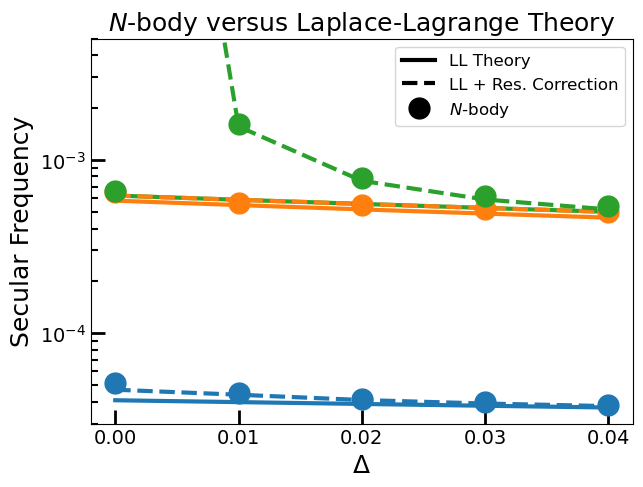

In [20]:
# Plot the results.

Delta = 2*periods/3-1
y1 = np.array([
    np.sort(np.abs(freqsAnalytic_NoCorrection[p]))
    for p in periods
])
y2 = np.array([
    np.sort(np.abs(freqsAnalytic_Corrected[p]))
    for p in periods
])
y3 = np.array([
    np.sort(np.abs(freqsNbody[p]))
    for p in periods
])

plt.figure(figsize=(7,5))
plt.yscale('log')
plt.ylim(3e-5,0.5e-2)
plt.xticks(np.linspace(0.0,0.04,5))
plt.title("$N$-body versus Laplace-Lagrange Theory",fontsize=18)
plt.ylabel("Secular Frequency",fontsize = 18)
plt.xlabel(r"$\Delta$",fontsize = 18)
plt.tick_params(labelsize=14,direction='in',width = 1.5,size=5, which='both')
plt.tick_params(size=10, width=2, which='major')
for i in range(3):
    l,=plt.plot(Delta,y1[:,i],lw=3,zorder=1)
    l,=plt.plot(Delta,y2[:,i],color=l.get_color(),ls='--',lw=3,zorder=2)
    l,=plt.plot(Delta,y3[:,i],'o',color=l.get_color(),zorder=3,ms=15)

from matplotlib.lines import Line2D
custom_lines=[
    Line2D([0],[0],color='k',ls='-',lw=3),
    Line2D([0],[0],color='k',ls='--',lw=3),
    Line2D([0],[0],color='k',marker='o',lw=0,ms=15)
]
plt.legend(custom_lines,['LL Theory','LL + Res. Correction',r'$N$-body'],prop={'size': 12})
    